# Hyper Parameter Tuning



## Imported Required Libraries

In [1]:
# Imported necessary PyTorch and torchvision modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
from google.colab import drive
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import os


## Connecting with google drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Seed for Reproducibility

In [3]:
# Sets random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# GPU Check and set for faster training times

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Path to the folder

In [5]:
dataset_dir = '/content/drive/MyDrive/Processed_plants'

## Transformations

 I converted images to tensors with pixel values between 0 and 1. Then, I tried a simple normalization with mean and std set to 0.5 for each RGB channel, scaling pixel values roughly between -1 and 1. However, the best practice is to calculate the actual mean and standard deviation from my dataset to normalize the images properly. This ensures the model trains on data with a distribution it expects. I wrote a small function to compute these statistics on my dataset and then used them in the normalization step. This improves model performance and stability during training.

In [6]:
# 1. Without normalization (just convert to tensor)
transform_without_norm = transforms.Compose([
    transforms.ToTensor()  # Converts PIL image to tensor with values in [0,1]
])

# Load dataset temporarily to calculate mean and std
temp_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform_without_norm)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to compute mean and std of dataset
def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (number of images)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (batch, channels, pixels)
        mean += images.mean(2).sum(0)  # mean per channel summed over batch
        std += images.std(2).sum(0)    # std per channel summed over batch
        total_images_count += batch_samples
    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Compute mean and std
mean, std = compute_mean_std(temp_loader)
print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

# 2. With normalization (using mean=0.5, std=0.5 for each channel)
transform_with_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Approximate normalization
])

# 3. With proper normalization using calculated dataset statistics
transform_with_proper_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Using calculated mean and std
])


Calculated mean: tensor([0.4617, 0.4617, 0.4617])
Calculated std: tensor([0.2398, 0.2398, 0.2398])


## Spliting Dataset into traning and testing

In [7]:
# Import necessary modules
from torch.utils.data import random_split, DataLoader
import torchvision.datasets as datasets

# Load dataset with basic transformation (no normalization) to split into train and test
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform_without_norm)

# Split the dataset: 80% training and 20% testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset_raw, test_dataset_raw = random_split(full_dataset, [train_size, test_size])


## Prepared Datasets for Each Normalization

In [8]:
# 1.Create dataset with NO normalization
dataset_without_norm = datasets.ImageFolder(root=dataset_dir, transform=transform_without_norm)
trainset_without_norm = torch.utils.data.Subset(dataset_without_norm, train_dataset_raw.indices)
testset_without_norm = torch.utils.data.Subset(dataset_without_norm, test_dataset_raw.indices)

# 2.Create dataset with simple normalization (mean=0.5, std=0.5)
dataset_with_norm = datasets.ImageFolder(root=dataset_dir, transform=transform_with_norm)
trainset_with_norm = torch.utils.data.Subset(dataset_with_norm, train_dataset_raw.indices)
testset_with_norm = torch.utils.data.Subset(dataset_with_norm, test_dataset_raw.indices)

# 3.Create dataset with proper normalization (calculated mean and std from dataset)
dataset_with_proper_norm = datasets.ImageFolder(root=dataset_dir, transform=transform_with_proper_norm)
trainset_with_proper_norm = torch.utils.data.Subset(dataset_with_proper_norm, train_dataset_raw.indices)
testset_with_proper_norm = torch.utils.data.Subset(dataset_with_proper_norm, test_dataset_raw.indices)


## DataLoaders for each Normalization

In [9]:
# batch size
batch_size = 32

# 1 Dataloaders for datasets without normalization
trainloader_without_norm = DataLoader(trainset_without_norm, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_without_norm = DataLoader(testset_without_norm, batch_size=batch_size, shuffle=False, num_workers=2)

# 2.Dataloaders for datasets with simple normalization
trainloader_with_norm = DataLoader(trainset_with_norm, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_with_norm = DataLoader(testset_with_norm, batch_size=batch_size, shuffle=False, num_workers=2)

# 3.Dataloaders for datasets with proper normalization (best practice)
trainloader_with_proper_norm = DataLoader(trainset_with_proper_norm, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_with_proper_norm = DataLoader(testset_with_proper_norm, batch_size=batch_size, shuffle=False, num_workers=2)


# Loading a batch and visualizeing

Sample Plant Images from the Dataset:


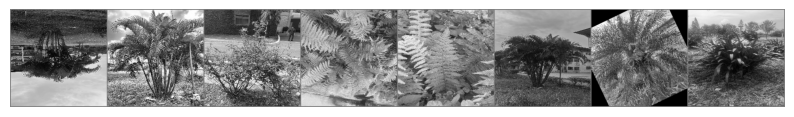

In [ ]:
# Function to show a grid of images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (only if normalization with mean=0.5 and std=0.5 is used)
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Gets a batch of images from the DataLoader
dataiter = iter(trainloader_with_norm)  # Or trainloader_without_norm or trainloader_with_proper_norm
images, labels = next(dataiter)

# Show first 8 images from the batch
print("Sample Plant Images from the Dataset:")
imshow(torchvision.utils.make_grid(images[:8]))




## Deep CNN Model

In [10]:
class DeepCNN(nn.Module):
    def __init__(self, init_method=None):
        super(DeepCNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: [B, 3, 28, 28] → Output: [B, 32, 28, 28]
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: [B, 64, 14, 14]
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)       # Reduces spatial dimensions by half
        self.dropout = nn.Dropout2d(0.25)    # Dropout for regularization

        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Ensure fixed size output before FC layers

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 10)          # Output layer for 10 classes (e.g., CIFAR-10)

        # Apply initialization method if specified
        if init_method == 'he':
            self._apply_he_initialization()   # Apply He initialization to weights

    def _apply_he_initialization(self):
        # Apply He initialization (Kaiming Normal) to Conv and Linear layers
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(layer.weight)     # He initialization
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)      # Initialize bias to zero

    def forward(self, x):
        # Forward pass through convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: [B, 32, 14, 14]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: [B, 64, 7, 7]
        x = self.adaptive_pool(x)                       # Ensure fixed feature map size
        x = self.dropout(x)                             # Apply dropout
        x = x.view(x.size(0), -1)                        # Flatten tensor for fully connected layers
        x = F.relu(self.fc1(x))                          # Fully connected + ReLU
        x = self.fc2(x)                                  # Output layer
        return x


## Train Test Functions

In [11]:
def train_model(model, trainloader, optimizer, criterion, scheduler=None, epochs=10):
    """Trains the model and records loss/accuracy history."""

    model.to(device)  # Move model to GPU/CPU as per 'device'

    # Lists to track training history
    train_loss_history = []
    train_acc_history = []

    for epoch in range(epochs):
        start_time = time.time()  # Start timer
        running_loss = 0.0        # Accumulates loss for reporting
        correct = 0               # Tracks correct predictions
        total = 0                 # Total samples seen

        model.train()  # Set model to training mode

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{epochs}, Learning Rate: {current_lr:.6f}')

        # Loop through training data
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Clear gradients from previous step

            outputs = model(inputs)      # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print every 100 mini-batches
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}, '
                      f'accuracy: {100 * correct / total:.2f}%')
                running_loss = 0.0  # Reset running loss for next display window

        # Adjust learning rate if scheduler is used
        if scheduler is not None:
            scheduler.step()

        # Compute epoch statistics
        epoch_loss = running_loss / len(trainloader)  # Average loss
        epoch_acc = 100 * correct / total             # Accuracy in %
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Print summary for epoch
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds. '
              f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    print('Finished Training')
    return train_loss_history, train_acc_history

def test_model(model, testloader):
    """Evaluate the model on the test set."""

    model.to(device)  # Move model to device (CPU/GPU)
    model.eval()      # Set model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation (faster and saves memory)
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class

            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Compute accuracy in %
    print(f'Accuracy on the test set: {accuracy:.2f}%')
    return accuracy




## Function to Visualize the accuracy and loss

In [12]:
def plot_training_history(title, *histories):
    """
    Plot training loss and accuracy histories for multiple models.

    Parameters:
    - title (str): Title prefix for the plots.
    - *histories: Tuples in the form (model_name, loss_history, acc_history).
    """
    plt.figure(figsize=(15, 5))  # Create a wide figure with 2 subplots

    # ----------- Plot Training Loss -----------
    plt.subplot(1, 2, 1)  # Left subplot for loss
    for name, loss_history, _ in histories:
        plt.plot(loss_history, label=name)
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # ----------- Plot Training Accuracy -----------
    plt.subplot(1, 2, 2)  # Right subplot for accuracy
    for name, _, acc_history in histories:
        plt.plot(acc_history, label=name)
    plt.title(f'{title} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Displays the plots


# Experiments Functions

In [13]:
def experiment_normalization(epochs=5):
    """Experiment with different normalization strategies."""
    print("\n=== EXPERIMENT: EFFECT OF NORMALIZATION ===")

    # I create models with He initialization
    model_without_norm = DeepCNN(init_method='he')
    model_with_norm = DeepCNN(init_method='he')
    model_with_proper_norm = DeepCNN(init_method='he')

    # I define the loss function and optimizer for each model
    criterion = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer_without_norm = optim.Adam(model_without_norm.parameters(), lr=lr)
    optimizer_with_norm = optim.Adam(model_with_norm.parameters(), lr=lr)
    optimizer_with_proper_norm = optim.Adam(model_with_proper_norm.parameters(), lr=lr)

    # I train models with different normalization strategies
    print("Training model without normalization...")
    history_without_norm = train_model(
        model_without_norm, trainloader_without_norm,
        optimizer_without_norm, criterion, epochs=epochs
    )

    print("\nTraining model with simple normalization [-1, 1]...")
    history_with_norm = train_model(
        model_with_norm, trainloader_with_norm,
        optimizer_with_norm, criterion, epochs=epochs
    )

    print("\nTraining model with proper normalization (dataset statistics)...")
    history_with_proper_norm = train_model(
        model_with_proper_norm, trainloader_with_proper_norm,
        optimizer_with_proper_norm, criterion, epochs=epochs
    )

    # I evaluate the models on the test set
    print("\nEvaluating on test set...")
    print("Model without normalization:")
    acc_without_norm = test_model(model_without_norm, testloader_without_norm)

    print("Model with simple normalization [-1, 1]:")
    acc_with_norm = test_model(model_with_norm, testloader_with_norm)

    print("Model with proper normalization (dataset statistics):")
    acc_with_proper_norm = test_model(model_with_proper_norm, testloader_with_proper_norm)

    # I plot the training histories for each model
    plot_training_history(
        "Effect of Normalization",
        ("No Normalization", *history_without_norm),
        ("Simple Normalization [-1, 1]", *history_with_norm),
        ("Proper Normalization", *history_with_proper_norm)
    )

    return {
        "No Normalization": acc_without_norm,
        "Simple Normalization [-1, 1]": acc_with_norm,
        "Proper Normalization": acc_with_proper_norm
    }

def experiment_optimizers(epochs=10):
    """Experiment with different optimizers."""
    print("\n=== EXPERIMENT: EFFECT OF DIFFERENT OPTIMIZERS ===")

    # I create models with He initialization
    model_sgd = DeepCNN(init_method='he')
    model_momentum = DeepCNN(init_method='he')
    model_rmsprop = DeepCNN(init_method='he')
    model_adam = DeepCNN(init_method='he')

    # I define the loss function and optimizers for each model
    criterion = nn.CrossEntropyLoss()
    lr = 0.01
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=lr)
    optimizer_momentum = optim.SGD(model_momentum.parameters(), lr=lr, momentum=0.9)
    optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=lr)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr)

    # I train models with different optimizers
    print("Training model with SGD...")
    history_sgd = train_model(
        model_sgd, trainloader_with_proper_norm,
        optimizer_sgd, criterion, epochs=epochs
    )

    print("\nTraining model with SGD + Momentum...")
    history_momentum = train_model(
        model_momentum, trainloader_with_proper_norm,
        optimizer_momentum, criterion, epochs=epochs
    )

    print("\nTraining model with RMSprop...")
    history_rmsprop = train_model(
        model_rmsprop, trainloader_with_proper_norm,
        optimizer_rmsprop, criterion, epochs=epochs
    )

    print("\nTraining model with Adam...")
    history_adam = train_model(
        model_adam, trainloader_with_proper_norm,
        optimizer_adam, criterion, epochs=epochs
    )

    # I test each model and print the accuracy
    print("\nEvaluating on test set...")
    print("Model with SGD:")
    acc_sgd = test_model(model_sgd, testloader_with_proper_norm)

    print("Model with SGD + Momentum:")
    acc_momentum = test_model(model_momentum, testloader_with_proper_norm)

    print("Model with RMSprop:")
    acc_rmsprop = test_model(model_rmsprop, testloader_with_proper_norm)

    print("Model with Adam:")
    acc_adam = test_model(model_adam, testloader_with_proper_norm)

    # I plot the results of each optimizer's performance
    plot_training_history(
        "Effect of Different Optimizers",
        ("SGD", *history_sgd),
        ("SGD + Momentum", *history_momentum),
        ("RMSprop", *history_rmsprop),
        ("Adam", *history_adam)
    )

    return {
        "SGD": acc_sgd,
        "SGD + Momentum": acc_momentum,
        "RMSprop": acc_rmsprop,
        "Adam": acc_adam
    }

def experiment_learning_rate_decay(epochs=15):
    """Experiment with different learning rate decay strategies."""
    print("\n=== EXPERIMENT: EFFECT OF LEARNING RATE DECAY ===")

    # I create models for different learning rate decay strategies
    model_constant = DeepCNN(init_method='he')
    model_step = DeepCNN(init_method='he')
    model_exp = DeepCNN(init_method='he')
    model_cosine = DeepCNN(init_method='he')

    # I define the loss function and optimizers for each model
    criterion = nn.CrossEntropyLoss()
    initial_lr = 0.01
    optimizer_constant = optim.SGD(model_constant.parameters(), lr=initial_lr, momentum=0.9)
    optimizer_step = optim.SGD(model_step.parameters(), lr=initial_lr, momentum=0.9)
    optimizer_exp = optim.SGD(model_exp.parameters(), lr=initial_lr, momentum=0.9)
    optimizer_cosine = optim.SGD(model_cosine.parameters(), lr=initial_lr, momentum=0.9)

    # I define schedulers for different learning rate decay strategies
    scheduler_step = StepLR(optimizer_step, step_size=5, gamma=0.1)
    scheduler_exp = ExponentialLR(optimizer_exp, gamma=0.9)
    scheduler_cosine = CosineAnnealingLR(optimizer_cosine, T_max=epochs)

    # I train models with different learning rate decay strategies
    print("Training model with constant learning rate...")
    history_constant = train_model(
        model_constant, trainloader_with_proper_norm,
        optimizer_constant, criterion, epochs=epochs
    )

    print("\nTraining model with step decay (factor of 0.1 every 5 epochs)...")
    history_step = train_model(
        model_step, trainloader_with_proper_norm,
        optimizer_step, criterion, scheduler=scheduler_step, epochs=epochs
    )

    print("\nTraining model with exponential decay (factor of 0.9 every epoch)...")
    history_exp = train_model(
        model_exp, trainloader_with_proper_norm,
        optimizer_exp, criterion, scheduler=scheduler_exp, epochs=epochs
    )

    print("\nTraining model with cosine annealing...")
    history_cosine = train_model(
        model_cosine, trainloader_with_proper_norm,
        optimizer_cosine, criterion, scheduler=scheduler_cosine, epochs=epochs
    )

    # I test each model and print the accuracy
    print("\nEvaluating on test set...")
    print("Model with constant learning rate:")
    acc_constant = test_model(model_constant, testloader_with_proper_norm)

    print("Model with step decay:")
    acc_step = test_model(model_step, testloader_with_proper_norm)

    print("Model with exponential decay:")
    acc_exp = test_model(model_exp, testloader_with_proper_norm)

    print("Model with cosine annealing:")
    acc_cosine = test_model(model_cosine, testloader_with_proper_norm)

    # I plot the results of each learning rate decay strategy
    plot_training_history(
        "Effect of Learning Rate Decay",
        ("Constant LR", *history_constant),
        ("Step Decay", *history_step),
        ("Exponential Decay", *history_exp),
        ("Cosine Annealing", *history_cosine)
    )

    return {
        "Constant LR": acc_constant,
        "Step Decay": acc_step,
        "Exponential Decay": acc_exp,
        "Cosine Annealing": acc_cosine
    }

def experiment_batch_size(epochs=5):
    """Experiment with different batch sizes while managing GPU memory."""
    print("\n=== EXPERIMENT: EFFECT OF BATCH SIZE ===")

    # Step 1: Define batch sizes (starting with small ones to avoid OOM)
    batch_sizes = [16, 64, 128, 256]  # Removed 1024 for safety

    # Step 2: Create dataloaders for each batch size
    trainloaders = {}
    for batch_size in batch_sizes:
        trainloaders[batch_size] = torch.utils.data.DataLoader(
            trainset_with_proper_norm, batch_size=batch_size,
            shuffle=True, num_workers=2
        )

    # Step 3: Train and test models
    models = {}
    histories = {}
    accuracies = {}

    for batch_size in batch_sizes:
        print(f"\nTraining model with batch size {batch_size}...")

        try:
            # Clear CUDA cache to free up memory
            torch.cuda.empty_cache()

            # Create a new model
            model = DeepCNN(init_method='he').to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Train model
            histories[batch_size] = train_model(
                model, trainloaders[batch_size],
                optimizer, criterion, epochs=epochs
            )

            # Evaluate model
            print(f"Model with batch size {batch_size}:")
            with torch.no_grad():
                acc = test_model(model, testloader_with_proper_norm)
            accuracies[batch_size] = acc

            # Store model if needed later
            models[batch_size] = model

            # Optional: Move model to CPU to free GPU memory
            model.to('cpu')
            del model
            torch.cuda.empty_cache()

        except RuntimeError as e:
            print(f" Failed for batch size {batch_size} due to: {e}")
            accuracies[batch_size] = None
            histories[batch_size] = ([], [])

    # Step 4: Plot training history
    plot_training_history(
        "Effect of Batch Size",
        *[(f"Batch Size {bs}", *histories[bs]) for bs in batch_sizes if histories[bs] != ([], [])]
    )

    return {f"Batch Size {bs}": accuracies[bs] for bs in batch_sizes}



# Experimenting and storeing results that the functions return

In [14]:
#  shorter epochs for quick experimentation
quick_epochs = 10


# Experiment 1: Effect of normalization


=== EXPERIMENT: EFFECT OF NORMALIZATION ===
Training model without normalization...
Epoch 1/10, Learning Rate: 0.001000
Epoch 1 completed in 4.65 seconds. Loss: 2.1480, Accuracy: 32.02%
Epoch 2/10, Learning Rate: 0.001000
Epoch 2 completed in 4.51 seconds. Loss: 1.3491, Accuracy: 54.19%
Epoch 3/10, Learning Rate: 0.001000
Epoch 3 completed in 3.48 seconds. Loss: 1.0456, Accuracy: 64.90%
Epoch 4/10, Learning Rate: 0.001000
Epoch 4 completed in 3.47 seconds. Loss: 0.8567, Accuracy: 72.32%
Epoch 5/10, Learning Rate: 0.001000
Epoch 5 completed in 4.40 seconds. Loss: 0.7077, Accuracy: 78.30%
Epoch 6/10, Learning Rate: 0.001000
Epoch 6 completed in 3.74 seconds. Loss: 0.6095, Accuracy: 78.69%
Epoch 7/10, Learning Rate: 0.001000
Epoch 7 completed in 3.43 seconds. Loss: 0.5611, Accuracy: 81.39%
Epoch 8/10, Learning Rate: 0.001000
Epoch 8 completed in 3.45 seconds. Loss: 0.4870, Accuracy: 83.41%
Epoch 9/10, Learning Rate: 0.001000
Epoch 9 completed in 4.58 seconds. Loss: 0.4510, Accuracy: 86.3

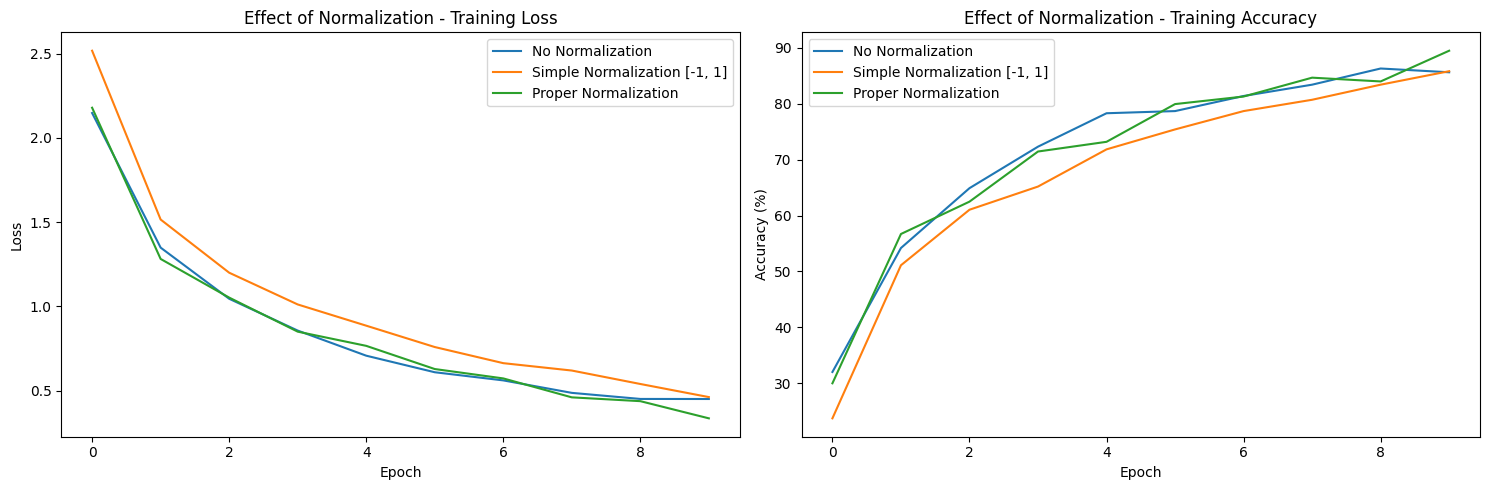

In [ ]:
results_norm = experiment_normalization(epochs=quick_epochs)

##  Experiment 2: Effect of different optimizers


=== EXPERIMENT: EFFECT OF DIFFERENT OPTIMIZERS ===
Training model with SGD...
Epoch 1/10, Learning Rate: 0.010000
Epoch 1 completed in 5.22 seconds. Loss: 2.1400, Accuracy: 26.42%
Epoch 2/10, Learning Rate: 0.010000
Epoch 2 completed in 3.89 seconds. Loss: 1.5974, Accuracy: 45.03%
Epoch 3/10, Learning Rate: 0.010000
Epoch 3 completed in 3.83 seconds. Loss: 1.3561, Accuracy: 54.97%
Epoch 4/10, Learning Rate: 0.010000
Epoch 4 completed in 4.97 seconds. Loss: 1.1763, Accuracy: 60.66%
Epoch 5/10, Learning Rate: 0.010000
Epoch 5 completed in 3.90 seconds. Loss: 1.0160, Accuracy: 65.67%
Epoch 6/10, Learning Rate: 0.010000
Epoch 6 completed in 4.01 seconds. Loss: 0.9376, Accuracy: 68.56%
Epoch 7/10, Learning Rate: 0.010000
Epoch 7 completed in 4.88 seconds. Loss: 0.8547, Accuracy: 74.35%
Epoch 8/10, Learning Rate: 0.010000
Epoch 8 completed in 4.12 seconds. Loss: 0.7857, Accuracy: 74.64%
Epoch 9/10, Learning Rate: 0.010000
Epoch 9 completed in 3.84 seconds. Loss: 0.7027, Accuracy: 78.59%
Epo

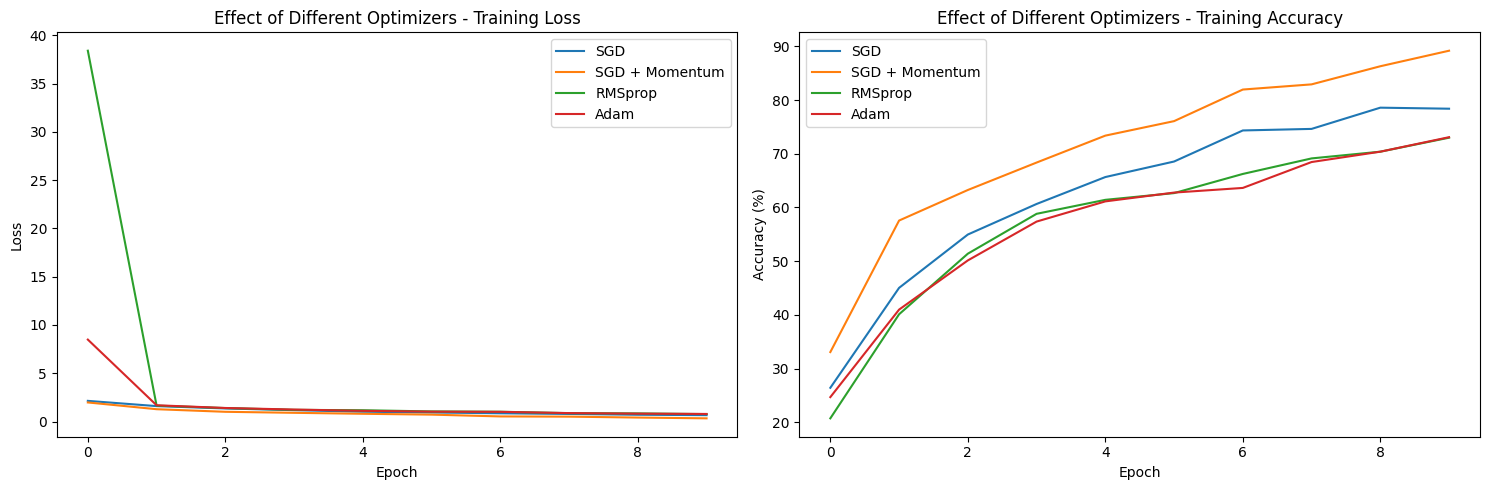

In [21]:
results_opt = experiment_optimizers(epochs=quick_epochs)

## Experiment 3: Effect of learning rate decay


=== EXPERIMENT: EFFECT OF LEARNING RATE DECAY ===
Training model with constant learning rate...
Epoch 1/10, Learning Rate: 0.010000
Epoch 1 completed in 5.25 seconds. Loss: 1.9380, Accuracy: 32.98%
New best accuracy 32.98% - saving model...
Model saved at /content/drive/MyDrive/Processed_plants/DeepCNN_best_model.pt
Epoch 2/10, Learning Rate: 0.010000
Epoch 2 completed in 3.76 seconds. Loss: 1.2980, Accuracy: 54.58%
New best accuracy 54.58% - saving model...
Model saved at /content/drive/MyDrive/Processed_plants/DeepCNN_best_model.pt
Epoch 3/10, Learning Rate: 0.010000
Epoch 3 completed in 4.05 seconds. Loss: 1.0005, Accuracy: 63.26%
New best accuracy 63.26% - saving model...
Model saved at /content/drive/MyDrive/Processed_plants/DeepCNN_best_model.pt
Epoch 4/10, Learning Rate: 0.010000
Epoch 4 completed in 4.81 seconds. Loss: 0.9217, Accuracy: 65.48%
New best accuracy 65.48% - saving model...
Model saved at /content/drive/MyDrive/Processed_plants/DeepCNN_best_model.pt
Epoch 5/10, Lea

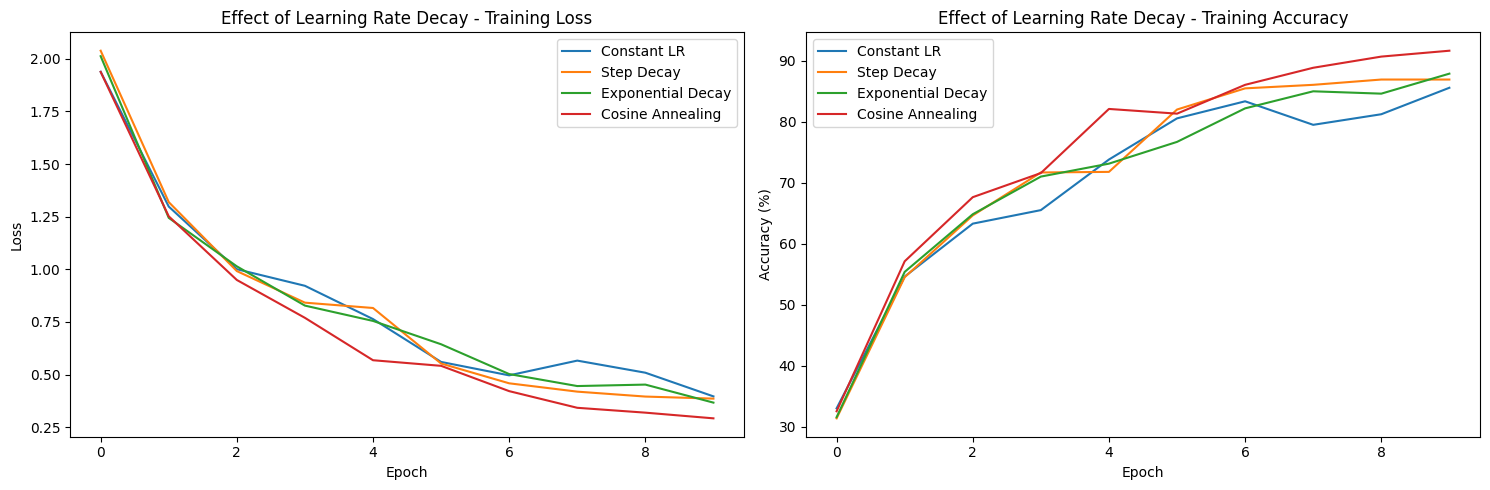

In [33]:
results_lr = experiment_learning_rate_decay(epochs=quick_epochs)

## Experiment 4: Effect of batch size


=== EXPERIMENT: EFFECT OF BATCH SIZE ===

Training model with batch size 16...
Epoch 1/10, Learning Rate: 0.001000
Epoch 1 completed in 4.75 seconds. Loss: 2.0493, Accuracy: 37.03%
Epoch 2/10, Learning Rate: 0.001000
Epoch 2 completed in 3.99 seconds. Loss: 1.2785, Accuracy: 55.83%
Epoch 3/10, Learning Rate: 0.001000
Epoch 3 completed in 3.72 seconds. Loss: 0.9835, Accuracy: 66.83%
Epoch 4/10, Learning Rate: 0.001000
Epoch 4 completed in 4.01 seconds. Loss: 0.8114, Accuracy: 73.19%
Epoch 5/10, Learning Rate: 0.001000
Epoch 5 completed in 4.48 seconds. Loss: 0.7253, Accuracy: 74.16%
Epoch 6/10, Learning Rate: 0.001000
Epoch 6 completed in 3.70 seconds. Loss: 0.6152, Accuracy: 78.98%
Epoch 7/10, Learning Rate: 0.001000
Epoch 7 completed in 3.74 seconds. Loss: 0.4991, Accuracy: 83.12%
Epoch 8/10, Learning Rate: 0.001000
Epoch 8 completed in 4.95 seconds. Loss: 0.4325, Accuracy: 86.11%
Epoch 9/10, Learning Rate: 0.001000
Epoch 9 completed in 3.71 seconds. Loss: 0.3571, Accuracy: 87.85%
Ep

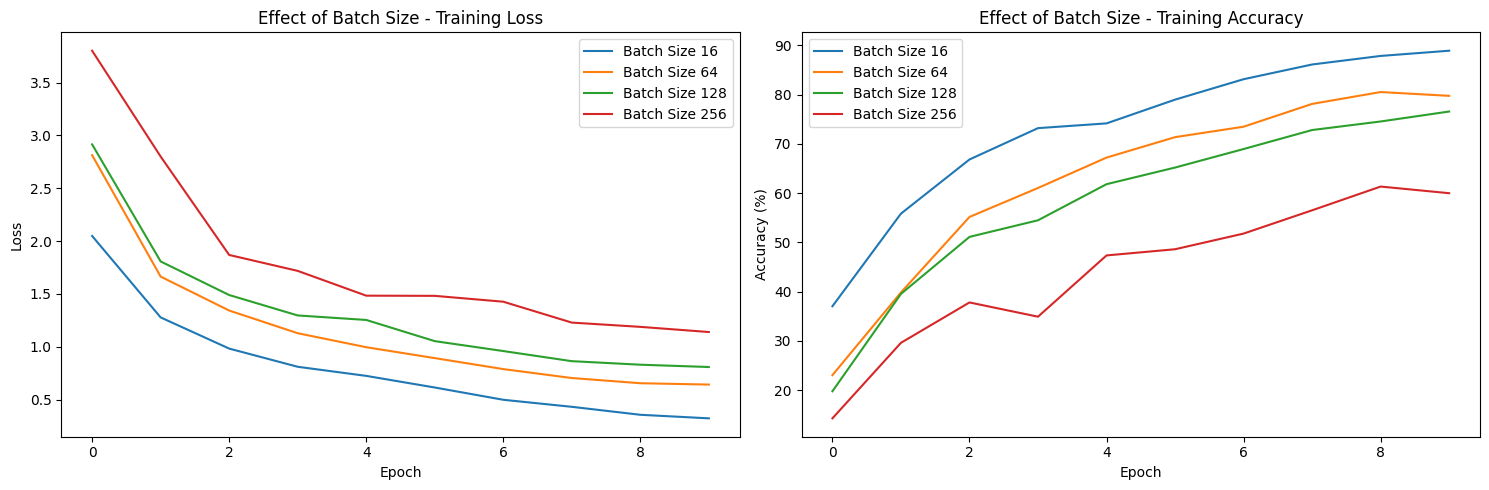

In [ ]:
results_batch = experiment_batch_size(epochs=quick_epochs)

## Summary of all results

In [ ]:
# Print summary of all results
print("\n=== SUMMARY OF RESULTS ===")

print("\nNormalization Experiment:")
for name, acc in results_norm.items():
    print(f"{name}: {acc:.2f}%")

print("\nOptimizers Experiment:")
for name, acc in results_opt.items():
    print(f"{name}: {acc:.2f}%")

print("\nLearning Rate Decay Experiment:")
for name, acc in results_lr.items():
    print(f"{name}: {acc:.2f}%")

print("\nBatch Size Experiment:")
for name, acc in results_batch.items():
    print(f"{name}: {acc:.2f}%")



=== SUMMARY OF RESULTS ===

Normalization Experiment:
No Normalization: 88.08%
Simple Normalization [-1, 1]: 80.00%
Proper Normalization: 85.00%

Optimizers Experiment:
SGD: 70.77%
SGD + Momentum: 80.00%
RMSprop: 65.38%
Adam: 58.46%

Learning Rate Decay Experiment:
Constant LR: 84.23%
Step Decay: 82.69%
Exponential Decay: 86.15%
Cosine Annealing: 90.77%

Batch Size Experiment:
Batch Size 16: 83.08%
Batch Size 64: 83.85%
Batch Size 128: 75.00%
Batch Size 256: 61.15%


## Save Best Model

In [32]:
# Path to save the best model
save_path = '/content/drive/MyDrive/Processed_plants/DeepCNN_best_model.pt'

best_acc = 0  # Initialize best accuracy tracker

def train_model(model, trainloader, optimizer, criterion, scheduler=None, epochs=10):
    """Trains the model and records loss/accuracy history."""

    model.to(device)  # Move model to GPU/CPU as per 'device'

    train_loss_history = []
    train_acc_history = []

    global best_acc  # To access best_acc variable outside the function

    for epoch in range(epochs):
        start_time = time.time()  # Start timer
        running_loss = 0.0        # Accumulates loss for reporting
        correct = 0               # Tracks correct predictions
        total = 0                 # Total samples seen

        model.train()  # Set model to training mode

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{epochs}, Learning Rate: {current_lr:.6f}')

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}, '
                      f'accuracy: {100 * correct / total:.2f}%')
                running_loss = 0.0

        if scheduler is not None:
            scheduler.step()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds. '
              f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        # ---- Here: Save the model if this epoch's accuracy is the best so far ----
        if epoch_acc > best_acc:
            best_acc = epoch_acc  # update best accuracy
            print(f"New best accuracy {best_acc:.2f}% - saving model...")
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

    print('Finished Training')
    return train_loss_history, train_acc_history
